# SpecUFEx Tutorial: The Geysers, California

Written by Theresa Sawi and Nate Groebner

Based on the study **Machine learning reveals cyclic changes in seismic source spectra in Geysers geothermal field** by Holtzman et al., 2018. DOI 10.1126/sciadv.aao2929

This example walks through fitting a SpecUFEx model to seismograms of approximately 5,000 microearthquakes from The Geysers geothermal field in California from 2012 to 2014. This is a subset of the 46,000 events that were analyzed in the study above. Using the features extracted by SpecUFEx, k-means clustering identifies 4 clusters of earthquake patterns that are correlated to rate of water flow into the injection wells.

## Tutorial Steps

1. Read in waveforms from hdf5 file.
2. Convert waveforms to spectrograms (filtered and median normalized)
3. Run SpecUFEx on spectrograms: Nonnegative matrix factorization followed by hidden markov model
4. Do kmeans clustering on SpecUFEx fingerprints
5. Compare clusters to paper figure 3c



### Imports

In [24]:
import glob
import h5py
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import obspy
import xml.etree.ElementTree as ET
import random
from tqdm import tqdm

# Set params

In [25]:
wf_H5_path = "./data/amatrice/waveforms_respremoved_1000.h5"

station_name = "T1214"
network = "IV"

freq_min, freq_max = 1, 40
preroll = 3  # seconds before P wave
postroll = 17  # seconds after P wave
num_samp = 1000  # number of samples for test run

# Load station info


In [26]:
# Namespace dictionary
namespaces = {"ns": "http://www.fdsn.org/xml/station/1"}


xml_iv = glob.glob("./data/amatrice/stations/IV/*.xml")
xml_yr = glob.glob("./data/amatrice/stations/YR/*.xml")

lat_sta_list = []
lon_sta_list = []
name_sta_list = []

for fi in [*xml_iv, *xml_yr]:
    # Parse the XML file
    tree = ET.parse(fi)
    root = tree.getroot()

    # Extract seismometer locations
    for station in root.findall(".//ns:Station", namespaces=namespaces):
        lat = float(station.find("ns:Latitude", namespaces=namespaces).text)
        lon = float(station.find("ns:Longitude", namespaces=namespaces).text)

        lat_sta_list.append(lat)
        lon_sta_list.append(lon)
        name_sta_list.append(fi.split(".")[-2])

## Load waveforms

The waveforms are saved to an hdf5 file. The waveforms and their IDs are loaded into numpy arrays and then stored in a pandas dataframe for easier manipulation.

Short Period - Identified in seismograms with the suffix "EHZ" - sensitive velocity seismometers with a response peaked around 1 Hz. Typically only a single vertical component. Primarily used for determination of locations and magnitudes of small regional earthquakes.

In [27]:
path_waves = f"./data/DATA_{station_name}/waves/{network}/{station_name}/EHZ*.mseed"
path_picks = "./data/hypoDD_20161013_20161018_ML.pha"

In [28]:
stream = obspy.Stream()
inv = obspy.read_inventory("./data/amatrice/stations/IV/IV.T1214.xml")

wavefiles = glob.glob(path_waves)
wavefiles.sort()

for fi in wavefiles:
    tr = obspy.read(fi, format="mseed")[0]
    tr.remove_response(inventory=inv, output="VEL")
    stream.append(tr)


stream.detrend("demean")  # Demean the data
stream.detrend("linear")  # Linear detrend the data
stream.filter("bandpass", freqmin=freq_min, freqmax=freq_max)
fs = stream[0].stats.sampling_rate

/Users/theresasawi/opt/anaconda3/envs/SCOPED/lib/python3.10/site-packages/obspy/core/inventory/response.py:959: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


# Read earthquakes and picks

In [29]:
# Read the text file
with open(path_picks, "r") as file:
    lines = file.readlines()

# Filter out lines not starting with '#'

event_lines = [line.strip() for line in lines if line.startswith("#")]
# Create pandas DataFrame

df_events = pd.DataFrame([line.split() for line in event_lines])

df_events.rename(
    {
        0: "#",
        1: "year",
        2: "month",
        3: "day",
        4: "hour",
        5: "minute",
        6: "second",
        7: "lat",
        8: "lon",
        9: "depth",
        10: "mag",
        14: "event_ID",
    },
    axis=1,
    inplace=True,
)
df_events["lon"] = df_events.lon.astype(float)
df_events["lat"] = df_events.lat.astype(float)
df_events["depth"] = df_events.depth.astype(float)
df_events["mag"] = df_events.mag.astype(float)

print(len(df_events))

16495


# Assign event_ID to each line not starting with # based on preceeding event line 

In [30]:
# Initialize variables
current_event_ID = None
data = []

# Iterate through the lines
for line in lines:
    line = line.strip()
    if line.startswith("#"):
        # Extract event_ID from the current line starting with '#'
        current_event_ID = line.split()[14]
    else:
        # For each entry not starting with '#', append it along with the event_ID to the data list
        data.append([current_event_ID] + line.split())

# Create pandas DataFrame
df_picks = pd.DataFrame(
    data, columns=["event_ID", "station", "rel_pick_time", "prob", "PorS", "component"]
)
df_picks.drop_duplicates(inplace=True)
# Get just P waves from HH component of netwrk station
df_picks_sta = df_picks[
    (df_picks.station == network + station_name)
    & (df_picks.component == "EH")
    & (df_picks.PorS == "P")
]

print(len(df_picks_sta))

9844


### Select a subset of the earthquakes


In [31]:
### Select a subset of the earthquakes
random.seed(0)
np.random.seed(0)


random_integers = random.sample(range(0, len(df_picks_sta) + 1), num_samp)

cat = df_picks_sta.iloc[random_integers].sort_values("event_ID")
df_events_subset = df_events[df_events.event_ID.isin(cat.event_ID)]
print(len(cat), len(df_events_subset))

1000 1000


# Make datetimes

In [32]:
datetime_list = [
    pd.to_datetime(
        f"{df_events_subset.iloc[i]['year']}/{df_events_subset.iloc[i]['month']}/{df_events_subset.iloc[i]['day']} {df_events_subset.iloc[i]['hour']}:{df_events_subset.iloc[i]['minute']}:{df_events_subset.iloc[i]['second']}"
    )
    for i in range(len(df_events_subset))
]

df_events_subset.loc[:, "otime"] = datetime_list

df_events_subset

/var/folders/tg/19dx30mj7bx0vw7hn2lf3j440000gn/T/ipykernel_20966/1489083379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events_subset.loc[:,'otime'] = datetime_list


,#,year,month,day,hour,minute,second,lat,lon,depth,mag,11,12,13,event_ID,15,otime
1,#,2016,10,13,0,0,6.34,42.7523,13.1802,3.04,-0.78,0.39,0.52,0.10,100002,E,2016-10-13 00:00:06.340
6,#,2016,10,13,0,1,34.43,42.8697,13.0733,1.82,0.32,0.17,0.40,0.22,100007,E,2016-10-13 00:01:34.430
7,#,2016,10,13,0,2,23.00,42.6430,13.2463,8.08,-0.31,0.45,0.84,0.23,100008,E,2016-10-13 00:02:23.000
36,#,2016,10,13,0,13,51.20,42.8095,13.2003,3.57,-0.22,0.36,1.25,0.31,100037,E,2016-10-13 00:13:51.200
43,#,2016,10,13,0,15,53.61,42.6847,13.2170,7.88,0.05,0.18,0.37,0.16,100044,E,2016-10-13 00:15:53.610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16394,#,2016,10,18,23,16,6.17,42.8197,13.1870,2.82,-0.14,0.19,0.44,0.20,116395,E,2016-10-18 23:16:06.170
16399,#,2016,10,18,23,17,57.58,42.8067,13.0865,5.50,0.04,0.18,0.49,0.17,116400,E,2016-10-18 23:17:57.580
16438,#,2016,10,18,23,34,15.06,42.8502,13.1568,4.40,0.03,0.33,1.11,0.34,116439,E,2016-10-18 23:34:15.060
16444,#,2016,10,18,23,36,16.65,42.8243,13.0503,3.32,-0.13,1.27,4.13,1.07,116445,E,2016-10-18 23:36:16.650


# Get waveforms

In [33]:
trace_ev_list = []
otimes_list = []
lat_list = []
lon_list = []
depth_list = []
evID_list = []
mag_list = []

total_iterations = len(df_events_subset)
# Iterate over DataFrame with tqdm progress bar
for i, row in tqdm(df_events_subset.iterrows(), total=total_iterations):
    stream_copy = stream.copy()

    evID = row.event_ID
    otime = row.otime
    lat = row.lat
    lon = row.lon
    depth = row.depth
    mag = row.mag

    df_picks_evID = cat[cat.event_ID == evID]
    pick_lag = df_picks_evID.rel_pick_time
    # print(row.day)

    if row.day == "13":
        tr = stream_copy[0].copy()

    elif row.day == "14":
        tr = stream_copy[1].copy()

    elif row.day == "15":
        tr = stream_copy[2].copy()

    elif row.day == "16":
        tr = stream_copy[3].copy()

    elif row.day == "17":
        tr = stream_copy[4].copy()

    else:
        tr = stream_copy[5].copy()

    starttime = otime + pd.Timedelta(seconds=float(pick_lag.iloc[0]) - preroll)
    endtime = otime + pd.Timedelta(seconds=float(pick_lag.iloc[0]) + postroll)

    trace_ev = tr.trim(
        starttime=obspy.UTCDateTime(starttime), endtime=obspy.UTCDateTime(endtime)
    )

    if len(trace_ev.data) == 2501:
        trace_ev_list.append(trace_ev)
        otimes_list.append(otime)
        lat_list.append(lat)
        lon_list.append(lon)
        depth_list.append(depth)
        mag_list.append(mag)
        evID_list.append(evID)
    elif len(trace_ev.data) == 2502:
        trace_ev_list.append(trace_ev[0:-1])
        otimes_list.append(otime)
        lat_list.append(lat)
        lon_list.append(lon)
        depth_list.append(depth)
        mag_list.append(mag)
        evID_list.append(evID)
    else:
        # print(len(trace_ev.data))
        pass

    del trace_ev, stream_copy

100%|███████████████████████████████████████| 1000/1000 [02:46<00:00,  6.00it/s]


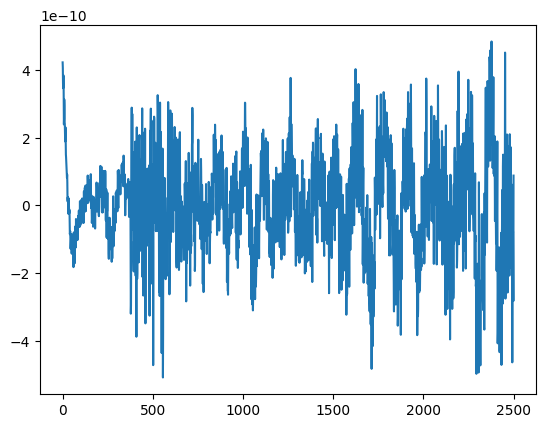

In [40]:
cat = pd.DataFrame(
    {
        "event_ID": evID_list,
        "otime": otimes_list,
        "lat": lat_list,
        "mag": mag_list,
        "lon": lon_list,
        "depth": depth_list,
    }
)

cat["waveform"] = trace_ev_list

plt.plot(trace_ev_list[0])

# Check lengths


In [41]:
# Check lengths

shapes = [len(s) for s in cat["waveform"]]

if all(shape == 2501 for shape in shapes):
    print("All elements of shapes are equal to 2501")
else:
    print("Not all elements of shapes are equal to 2501")


indices_not_2501 = [i for i, shape in enumerate(shapes) if shape != 2501]

print("Indices where elements are not equal to 2501:", indices_not_2501)

All elements of shapes are equal to 2501
Indices where elements are not equal to 2501: []


# Plotting


13.208697 42.759537


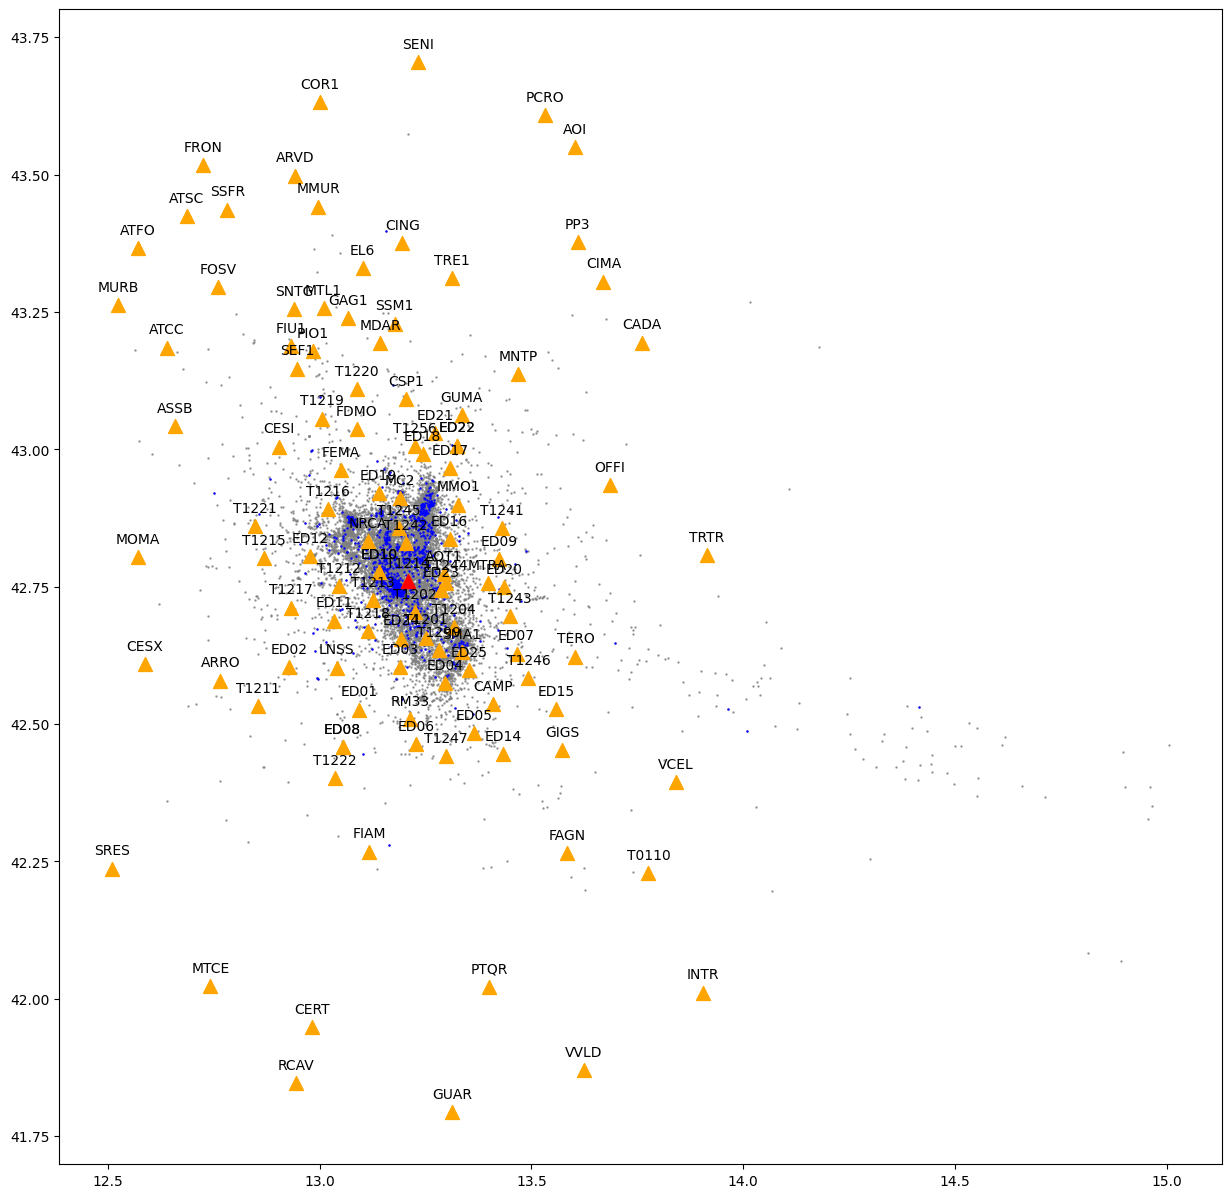

In [42]:
# Plotting

plt.figure(figsize=(15, 15))
plt.scatter(df_events.lon, df_events.lat, s=0.5, color="grey", alpha=0.8)
plt.scatter(cat.lon, cat.lat, s=0.5, color="blue")

plt.scatter(lon_sta_list, lat_sta_list, s=100, marker="^", c="orange")
# Add labels to each point
for i, txt in enumerate(name_sta_list):
    plt.annotate(
        txt,
        (lon_sta_list[i], lat_sta_list[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )

    if txt == station_name:
        plt.scatter(lon_sta_list[i], lat_sta_list[i], s=100, marker="^", c="red")
        print(lon_sta_list[i], lat_sta_list[i])

# Create H5 catalog

In [43]:
with h5py.File(wf_H5_path, "w") as f:
    f.create_dataset("waveform", data=np.stack(cat["waveform"].values))
    f.create_dataset("event_ID", data=list(cat["event_ID"].values))
    f.create_dataset("otime", data=list(cat["otime"].astype("str").values))
    f.create_dataset("lat", data=list(cat["lat"].values))
    f.create_dataset("lon", data=list(cat["lon"].values))
    f.create_dataset("depth", data=list(cat["depth"].values))
    f.create_dataset("mag", data=list(cat["mag"].values))
    f.create_dataset("sampling_rate", data=fs)